In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook

%load_ext autoreload
%autoreload 2


In [2]:
run_path_server1="/data/tianyu_guo/birth/gens/pre_final/dormant_test"
run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server1, n_layers=1, n_heads=1, bos_num=1, train_steps=5000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

In [6]:
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

In [3]:
# torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())

(84538425344, 84986691584)


In [4]:
outputs_list_steps = {}
steps_list = []
n_layers, n_heads, bos_num = 1, 1, 1
# f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/state_{train_steps}.pt"
dir_name = f"/data/tianyu_guo/birth/gens/pre_final/dormant_test/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0"
model = model.cuda()
x = x.cuda()
with torch.no_grad():
    for fn in os.listdir(dir_name):
        if 'state' not in fn:
            continue
        step = int(fn.split('.')[0].split('_')[1])
        steps_list.append(step)
        state = torch.load(os.path.join(dir_name, fn), map_location="cuda")
        model.load_state_dict(state["model_state_dict"], strict=False, )
        predicts, outputs_list = model.modified_forward_with_hook(x, hook)
        outputs_list = move_device(outputs_list)
        outputs_list_steps[step] = outputs_list
        print(step)
steps_list.sort()

(83873628160, 84986691584)
(83869433856, 84986691584)
(83867336704, 84986691584)
(83867336704, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(

In [131]:
len(steps_list)

205

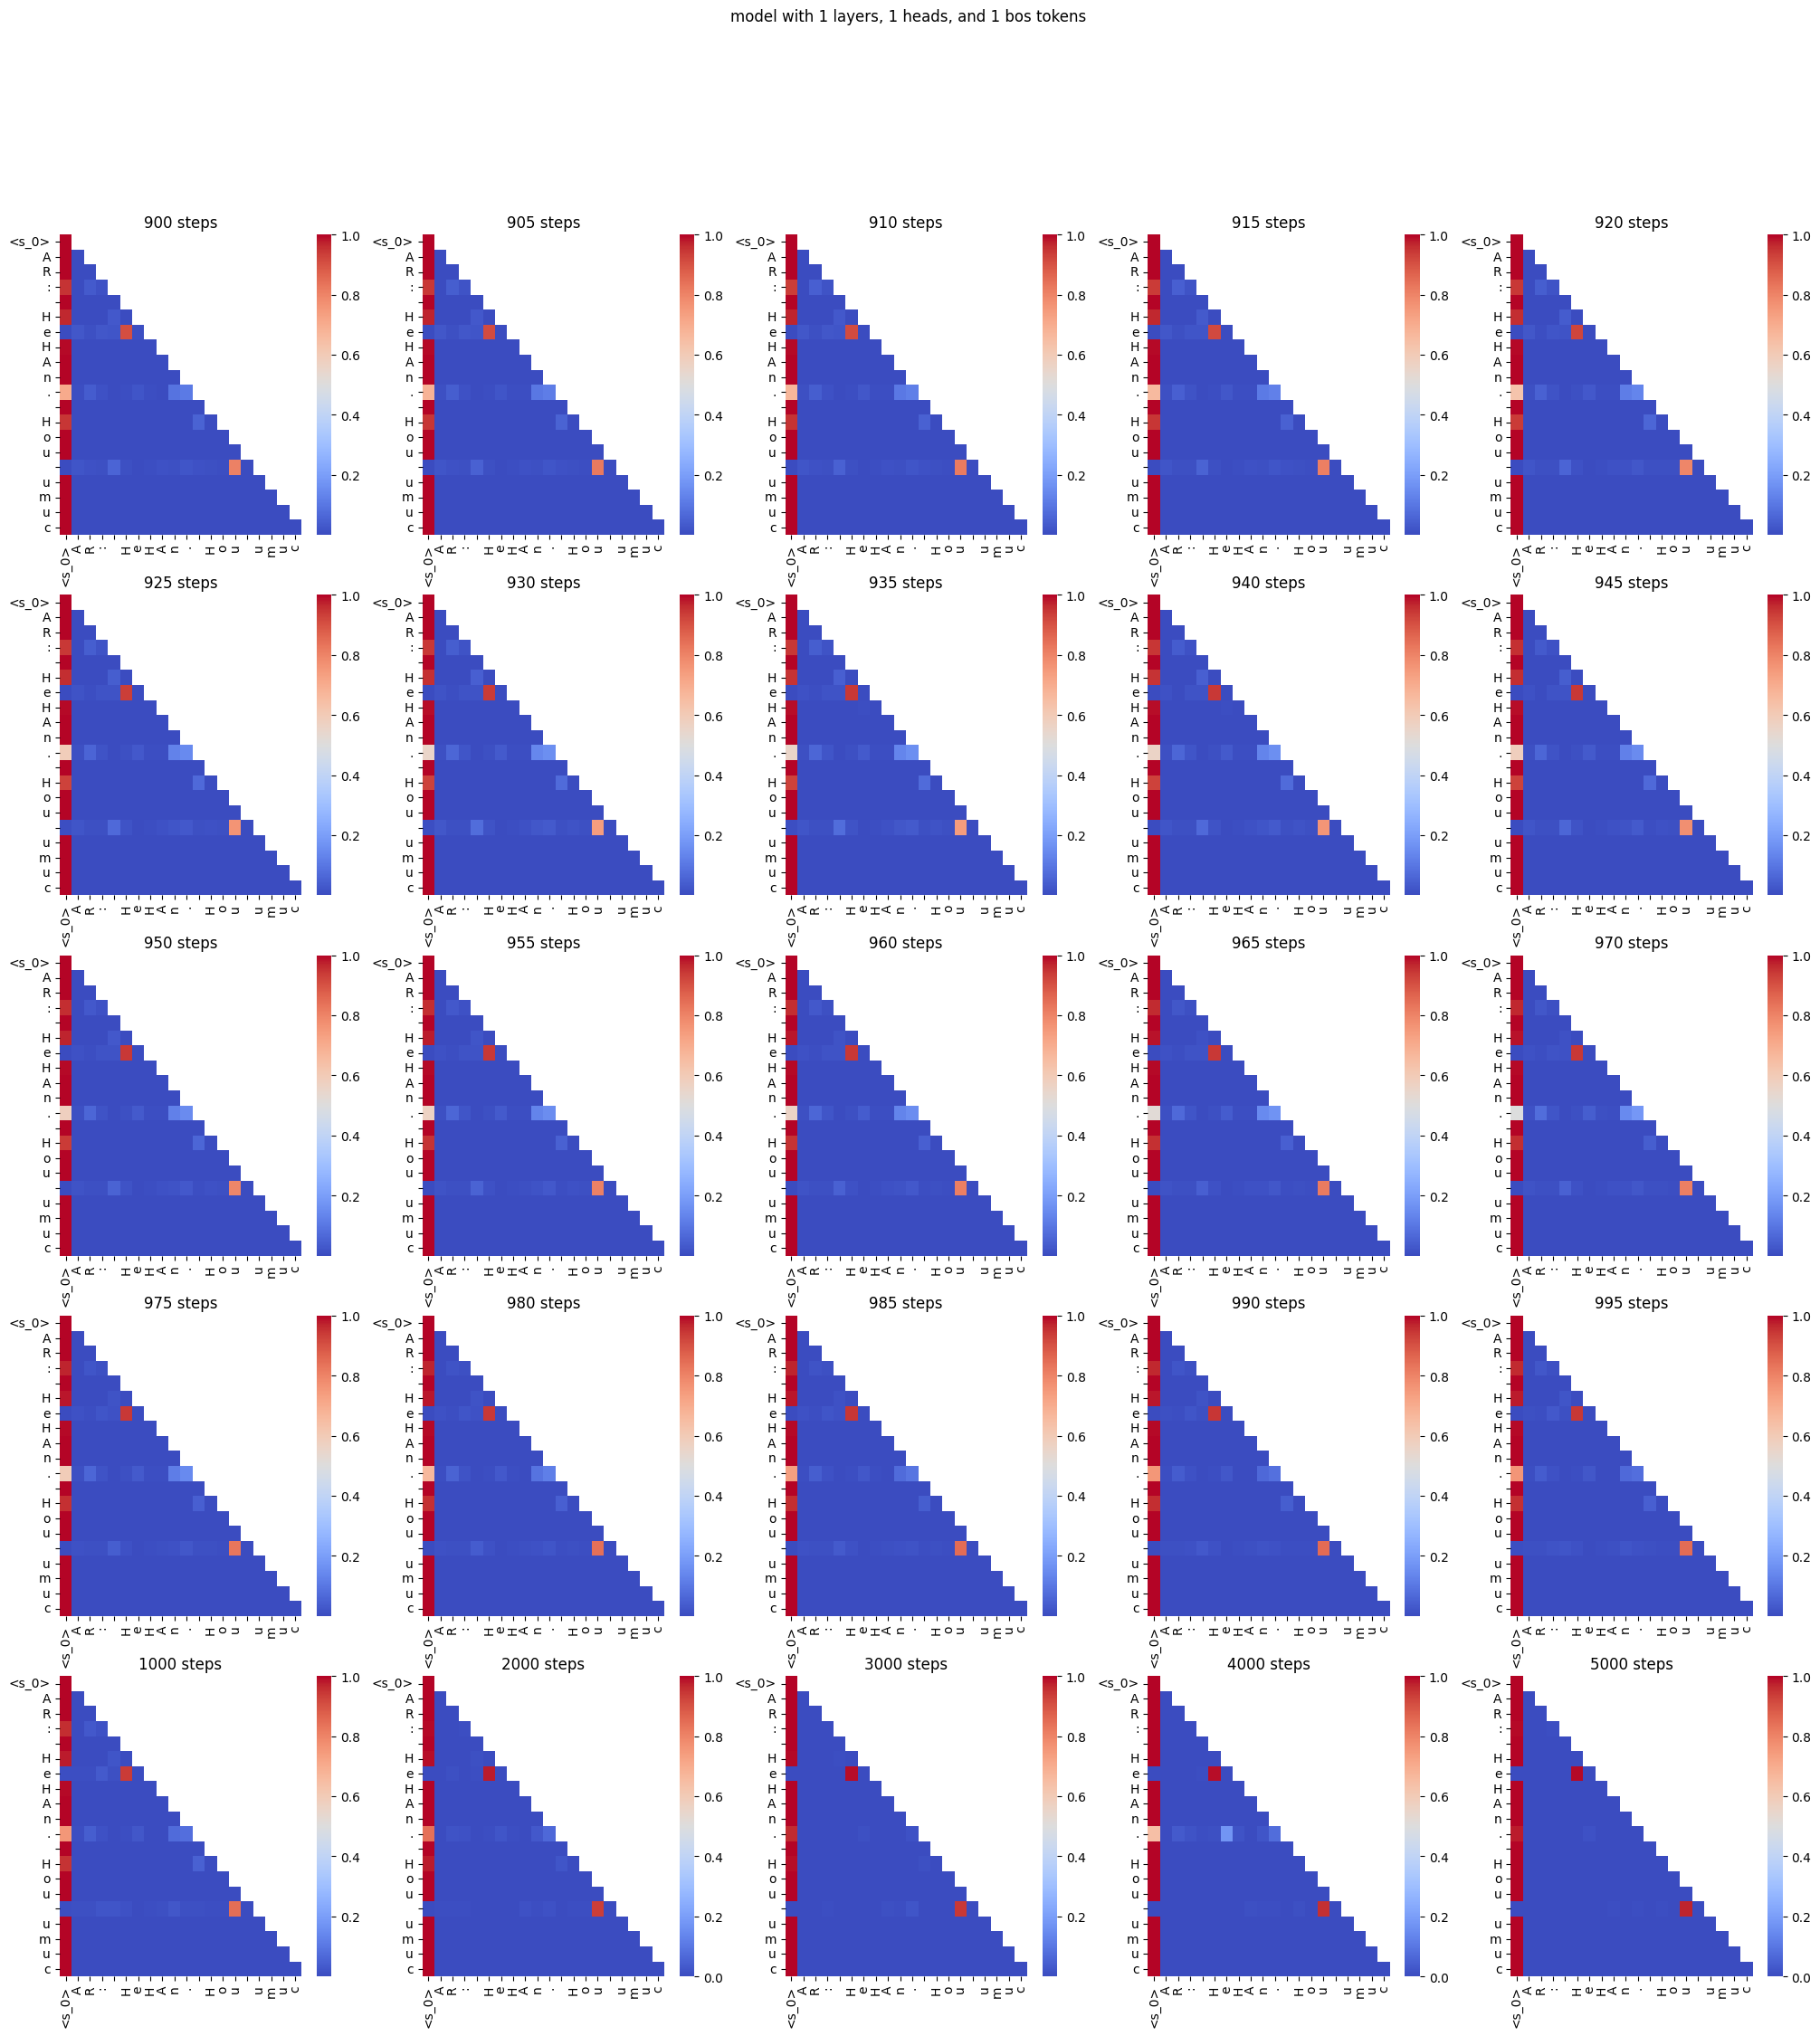

In [44]:
# scores = data['scores'][layer_idx]
start_step = 180
steps_subset = steps_list[start_step:start_step+25]
seq_len = 20
seq_idx = 6
text = ds.decode(x.detach().cpu()[seq_idx, :seq_len].numpy())

fig, axes = plt.subplots(5, 5, figsize=(5*5, 5*5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    step = steps_subset[i]
    # hacky
    plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list_steps[step], text)
    # ax.set_xticks(list(ds.decode(x[seq_idx, :20].numpy())))
    ax.set_title(f"{step} steps")
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()